In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score, precision_recall_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import shap
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
#plt.style.use('seaborn-whitegrid')
sns.set_palette("Set2")

In [24]:
data = pd.read_csv('TelcoCustomerChurn.csv')

# Display basic information
print(f"Dataset dimensions: {data.shape}")
print("\nFirst few rows:")
display(data.head())

# Check data types and missing values
print("\nData types and missing values:")
display(data.info())

Dataset dimensions: (7043, 21)

First few rows:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessB

None

**Step 2: Explore the Data**


Class distribution in target variable:
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64
Imbalance ratio: 1:2.77


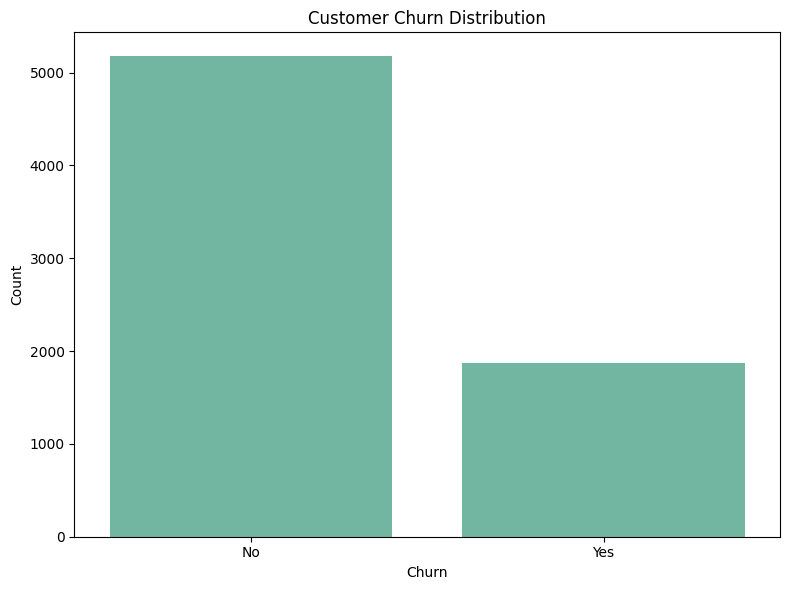

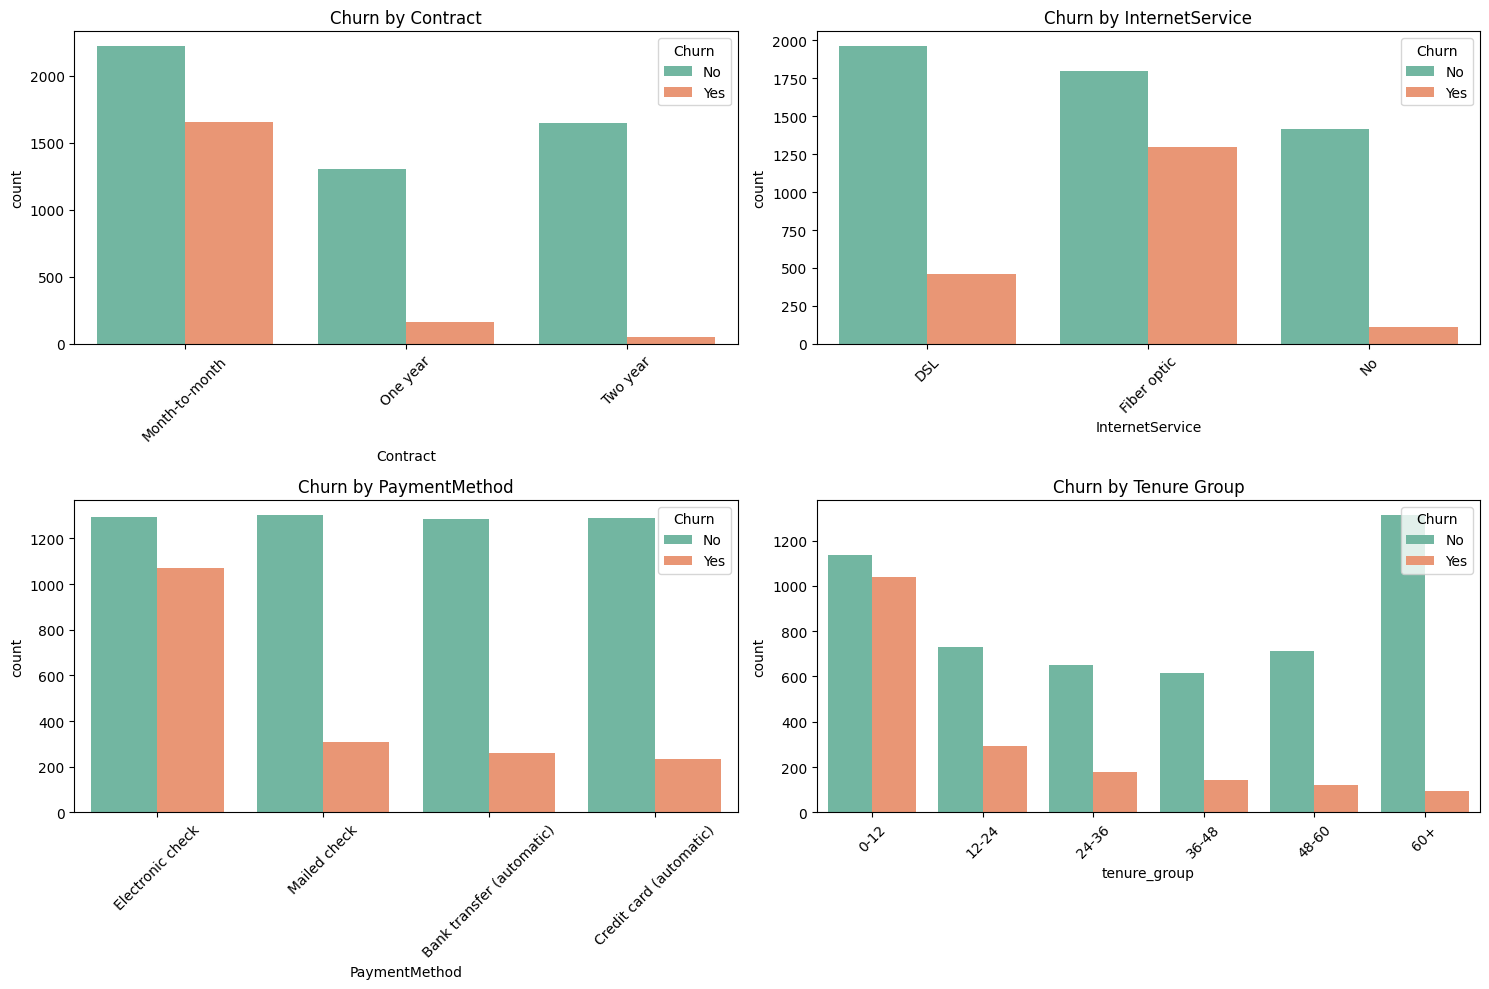

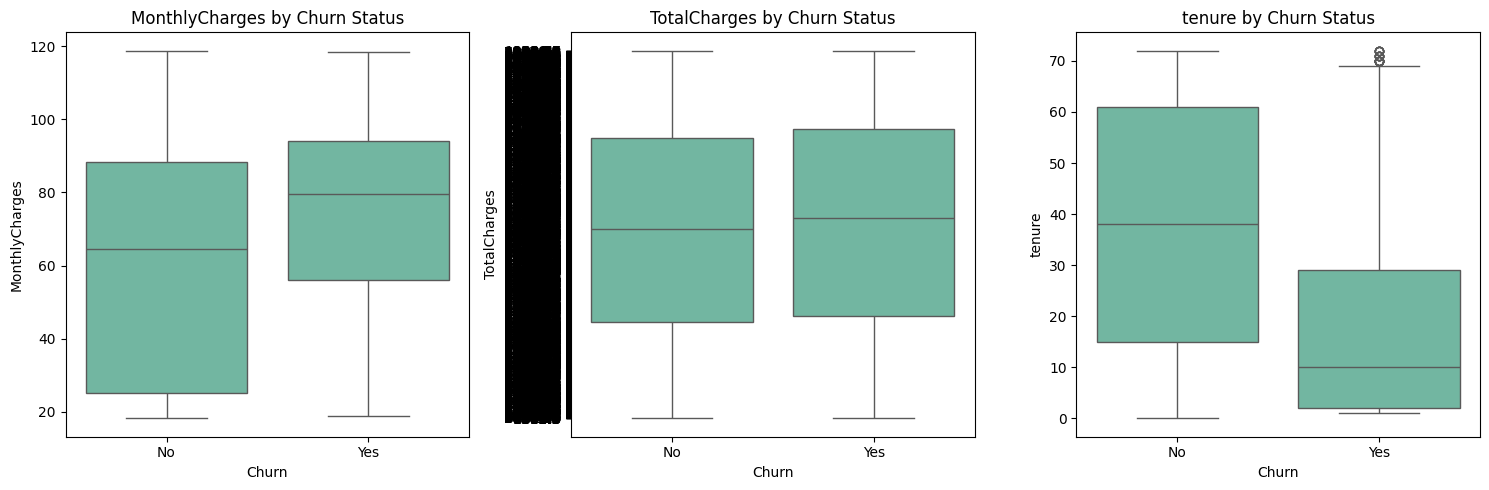

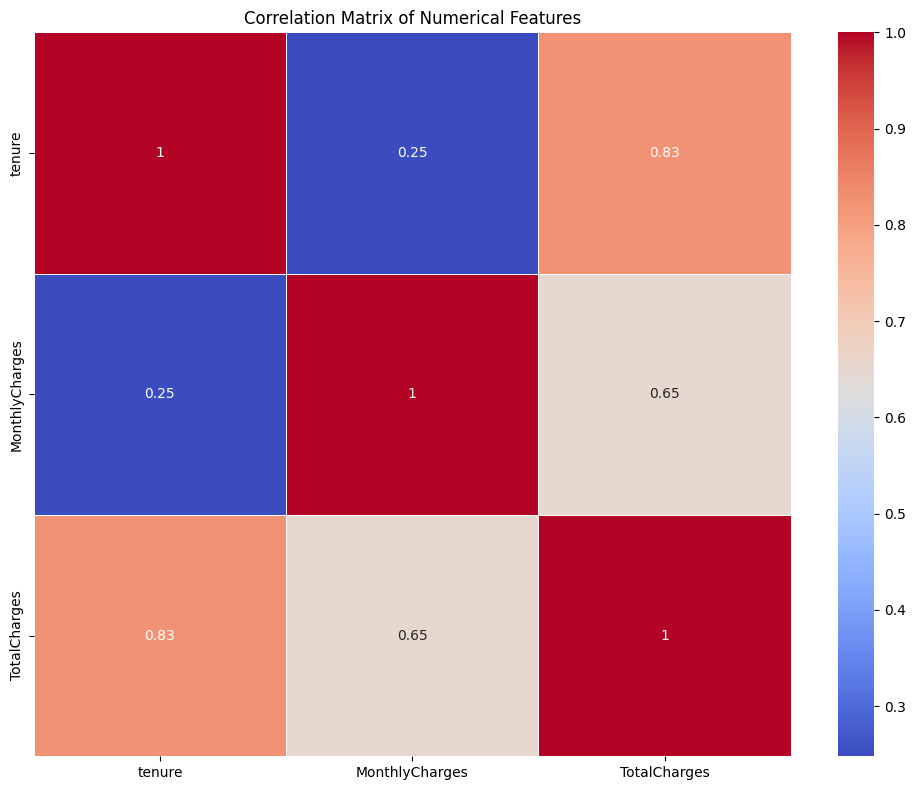

In [25]:




# Check for class imbalance in the target variable
print("\nClass distribution in target variable:")
churn_distribution = data['Churn'].value_counts(normalize=True) * 100
print(churn_distribution)
print(f"Imbalance ratio: 1:{round(churn_distribution[0]/churn_distribution[1], 2)}")

# Plot the class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Churn', data=data)
plt.title('Customer Churn Distribution')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# %%
# Explore relationships between categorical variables and churn
plt.figure(figsize=(15, 10))

categorical_cols = ['Contract', 'InternetService', 'PaymentMethod', 'tenure']
for i, col in enumerate(categorical_cols[:3], 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=col, hue='Churn', data=data)
    plt.title(f'Churn by {col}')
    plt.xticks(rotation=45)
    plt.legend(title='Churn', loc='upper right')

# For tenure (converting to categorical temporarily for visualization)
plt.subplot(2, 2, 4)
data['tenure_group'] = pd.cut(data['tenure'], bins=[0, 12, 24, 36, 48, 60, 72],
                           labels=['0-12', '12-24', '24-36', '36-48', '48-60', '60+'])
sns.countplot(x='tenure_group', hue='Churn', data=data)
plt.title('Churn by Tenure Group')
plt.xticks(rotation=45)
plt.legend(title='Churn', loc='upper right')

plt.tight_layout()
plt.show()

# %%
# Explore relationships between numerical variables and churn
plt.figure(figsize=(15, 5))

numerical_cols = ['MonthlyCharges', 'TotalCharges', 'tenure']
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='Churn', y=col, data=data)
    plt.title(f'{col} by Churn Status')

plt.tight_layout()
plt.show()

# %%
# Correlation heatmap for numerical variables
# Convert TotalCharges to numeric
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

plt.figure(figsize=(10, 8))
correlation_matrix = data[['tenure', 'MonthlyCharges', 'TotalCharges']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

**Step 3: Preprocess Data and Engineer Features**


Top correlations with churn:
Churn                     1.000000
ContractRiskLevel         0.396713
CostRateOfChange          0.386198
SpendingRate              0.382297
AvgServiceCharge          0.287557
MonthlyCharges            0.193356
HasMultipleServices       0.065665
ServiceChangeIndicator    0.005059
TotalServices            -0.030765
IsHighValueCustomer      -0.055853
TotalCharges             -0.198324
Name: Churn, dtype: float64


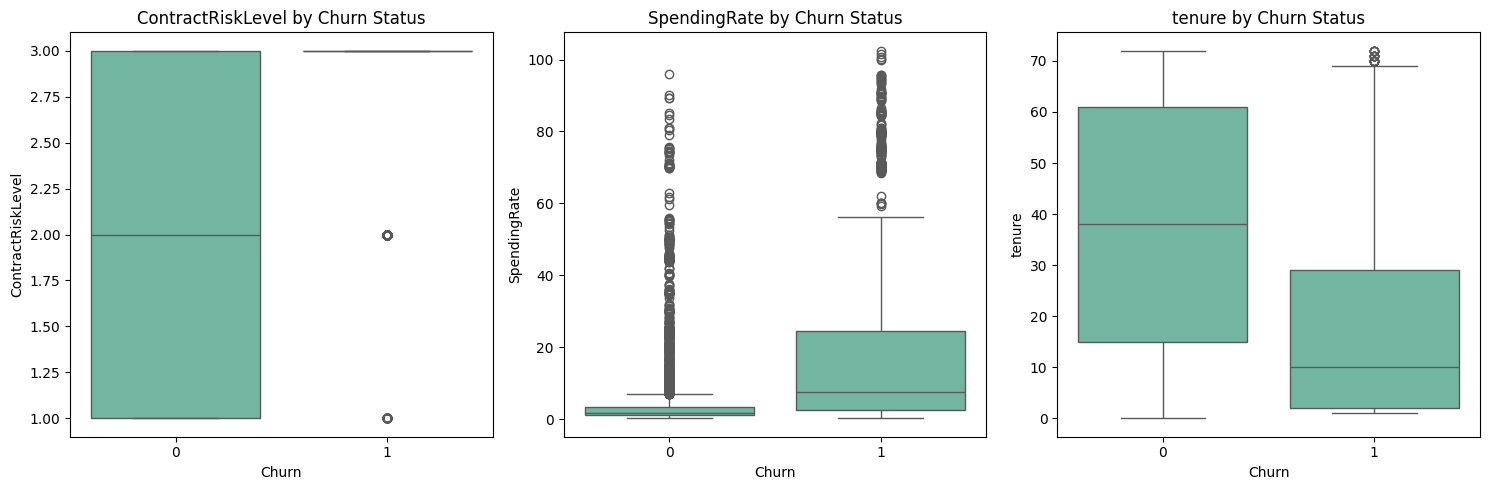

In [26]:
df = data.copy()

# Convert categorical target to numeric
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Convert 'TotalCharges' to numeric if not already done
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Fill missing values
df['TotalCharges'].fillna(df['MonthlyCharges'] * df['tenure'], inplace=True)

# Create tenure groups as a new feature
df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 12, 24, 36, 48, 60, 72],
                           labels=['0-12 months', '12-24 months', '24-36 months',
                                   '36-48 months', '48-60 months', '60+ months'])

# %%
# Feature Engineering

# 1. Create total services count
service_columns = ['PhoneService', 'InternetService', 'OnlineSecurity',
                   'OnlineBackup', 'DeviceProtection', 'TechSupport',
                   'StreamingTV', 'StreamingMovies']

# Initialize service count
df['TotalServices'] = 0

# Count phone service
df.loc[df['PhoneService'] == 'Yes', 'TotalServices'] += 1

# Count internet-related services
internet_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                     'TechSupport', 'StreamingTV', 'StreamingMovies']

for service in internet_services:
    df.loc[df[service] == 'Yes', 'TotalServices'] += 1

# Count type of internet service separately
df.loc[df['InternetService'] != 'No', 'TotalServices'] += 1

# %%
# 2. Create average monthly charge per service
df['AvgServiceCharge'] = df['MonthlyCharges'] / df['TotalServices'].apply(lambda x: max(x, 1))

# 3. Calculate charge per tenure ratio (customer spending rate)
df['SpendingRate'] = df['MonthlyCharges'] / df['tenure'].apply(lambda x: max(x, 1))

# 4. Customer loyalty (binary feature for customers with long tenure)
df['IsLoyalCustomer'] = (df['tenure'] > 24).astype(int)

# 5. Identify customers with multiple services
df['HasMultipleServices'] = (df['TotalServices'] > 2).astype(int)

# 6. Create service change indicator (proxy from total vs monthly charges ratio)
df['ServiceChangeIndicator'] = df['TotalCharges'] / (df['MonthlyCharges'] * df['tenure'].apply(lambda x: max(x, 1)))

# 7. Calculate monthly cost rate of change
df['CostRateOfChange'] = df['TotalCharges'] / (df['tenure'].apply(lambda x: max(x, 1))**2)

# 8. High-value customer flag
df['IsHighValueCustomer'] = ((df['MonthlyCharges'] > df['MonthlyCharges'].quantile(0.75)) &
                           (df['tenure'] > df['tenure'].quantile(0.5))).astype(int)

# 9. Contract risk level (higher for month-to-month)
contract_risk = {'Month-to-month': 3, 'One year': 2, 'Two year': 1}
df['ContractRiskLevel'] = df['Contract'].map(contract_risk)

# %%
# Identify columns for modeling

# Categorical features
categorical_features = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                       'PaperlessBilling', 'PaymentMethod', 'tenure_group']

# Numerical features
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'TotalServices',
                     'AvgServiceCharge', 'SpendingRate', 'IsLoyalCustomer',
                     'HasMultipleServices', 'ServiceChangeIndicator', 'CostRateOfChange',
                     'IsHighValueCustomer', 'ContractRiskLevel']

# Target variable
target = 'Churn'

# %%
# Analyze feature relationships with churn
print("\nTop correlations with churn:")
correlations = df[numerical_features + [target]].corr()['Churn'].sort_values(ascending=False)
print(correlations.head(11))

# Visualize key numerical features relationship with churn
plt.figure(figsize=(15, 5))
key_features = ['ContractRiskLevel', 'SpendingRate', 'tenure']
for i, feature in enumerate(key_features, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='Churn', y=feature, data=df)
    plt.title(f'{feature} by Churn Status')

plt.tight_layout()
plt.show()


**Step 4: Split Data and Handle Imbalance**

In [27]:
X = df[categorical_features + numerical_features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                   random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Class distribution in training set: \n{y_train.value_counts(normalize=True) * 100}")

# %%
# Create preprocessor for the pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


Training set shape: (5282, 28)
Testing set shape: (1761, 28)
Class distribution in training set: 
Churn
0    73.457024
1    26.542976
Name: proportion, dtype: float64


Step 5: Build Classification Models


Training Logistic Regression...

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1294
           1       0.52      0.77      0.62       467

    accuracy                           0.75      1761
   macro avg       0.71      0.76      0.72      1761
weighted avg       0.80      0.75      0.76      1761

Confusion Matrix:
[[963 331]
 [107 360]]

Training Random Forest...

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1294
           1       0.60      0.55      0.57       467

    accuracy                           0.78      1761
   macro avg       0.72      0.71      0.71      1761
weighted avg       0.78      0.78      0.78      1761

Confusion Matrix:
[[1127  167]
 [ 212  255]]

Training Gradient Boosting...

Classification Report for Gradient Boosting:
              precision    recall

,Model,Accuracy,F1 Score,ROC AUC,PR AUC
0,Logistic Regression,0.751278,0.621762,0.845186,0.655029
1,Random Forest,0.784781,0.573678,0.824173,0.611449
2,Gradient Boosting,0.781374,0.609137,0.839524,0.642479
3,XGBoost,0.776831,0.564784,0.819037,0.604637


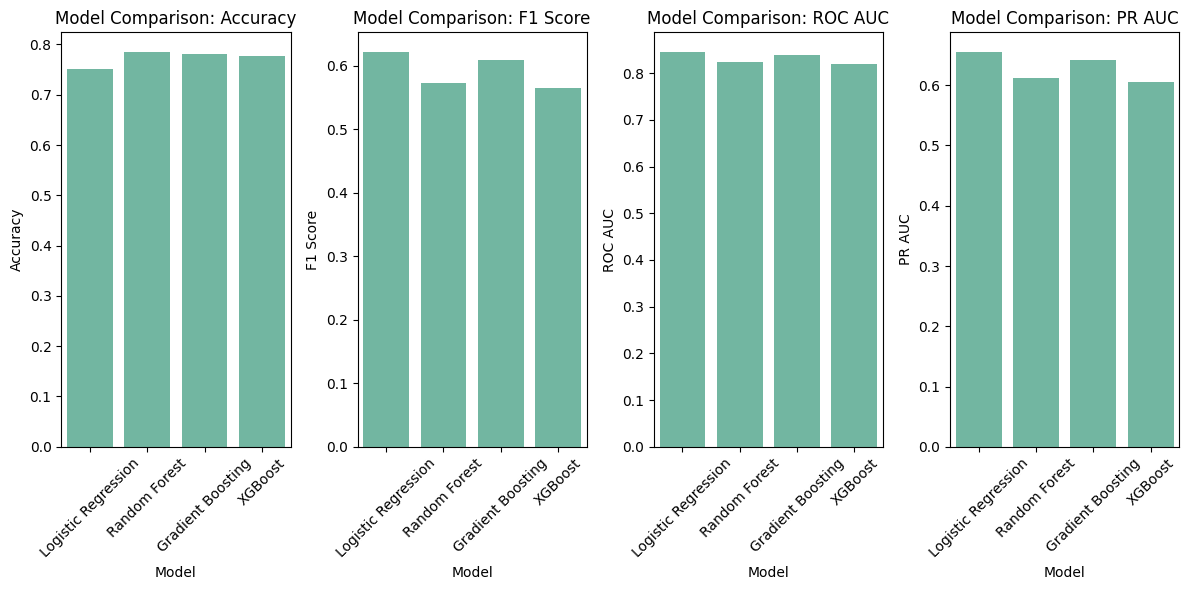


Best model: Random Forest with PR AUC of 0.7848


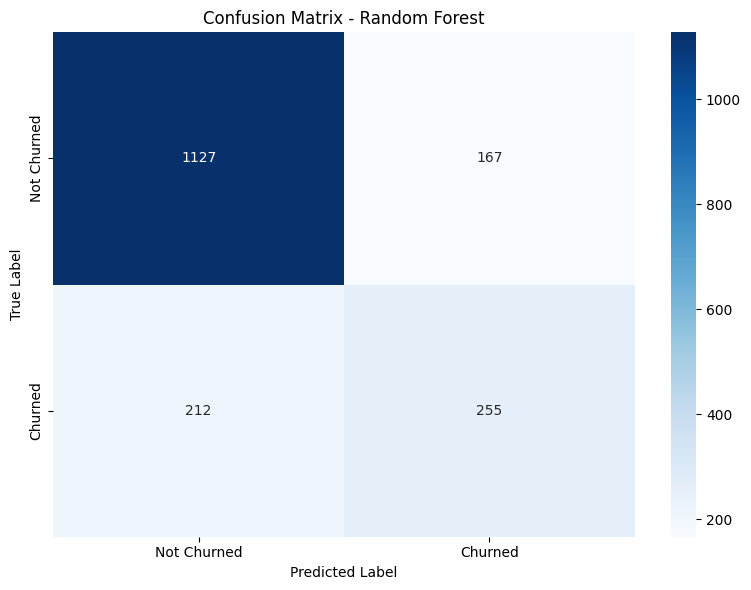

In [36]:
model_results = []

# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Create pipeline with SMOTE for handling imbalance
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Precision-Recall AUC (better for imbalanced data)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    # Store results
    model_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'PR AUC': pr_auc,
        'Pipeline': pipeline
    })

    # Print classification report
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred))

    # Print confusion matrix
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

# %%
# Create a dataframe to compare models
results_df = pd.DataFrame(model_results)
print("\nModel Comparison:")
display(results_df[['Model', 'Accuracy', 'F1 Score', 'ROC AUC', 'PR AUC']])

# Visualize model performance
plt.figure(figsize=(12, 6))
metrics = ['Accuracy', 'F1 Score', 'ROC AUC', 'PR AUC']
for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 4, i)
    sns.barplot(x='Model', y=metric, data=results_df)
    plt.title(f'Model Comparison: {metric}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# %%
# Find the best model based on PR AUC (best for imbalanced data)
best_model_idx = results_df['Accuracy'].idxmax()
best_model = results_df.loc[best_model_idx]
print(f"\nBest model: {best_model['Model']} with Accuracy of {best_model['Accuracy']:.4f}")

# Plot confusion matrix for the best model
best_pipeline = best_model['Pipeline']
y_pred_best = best_pipeline.predict(X_test)
cm_best = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Not Churned', 'Churned'],
           yticklabels=['Not Churned', 'Churned'])
plt.title(f'Confusion Matrix - {best_model["Model"]}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

**Step 6: Model Interpretability**


Top 15 most important features:
1. SpendingRate: 0.0892
2. CostRateOfChange: 0.0829
3. MonthlyCharges: 0.0526
4. AvgServiceCharge: 0.0521
5. tenure: 0.0500
6. TotalCharges: 0.0500
7. ContractRiskLevel: 0.0496
8. PaymentMethod_Electronic check: 0.0454
9. ServiceChangeIndicator: 0.0445
10. Contract_Month-to-month: 0.0436
11. TechSupport_No: 0.0338
12. OnlineSecurity_No: 0.0313
13. PaperlessBilling_No: 0.0180
14. TotalServices: 0.0180
15. PaperlessBilling_Yes: 0.0177


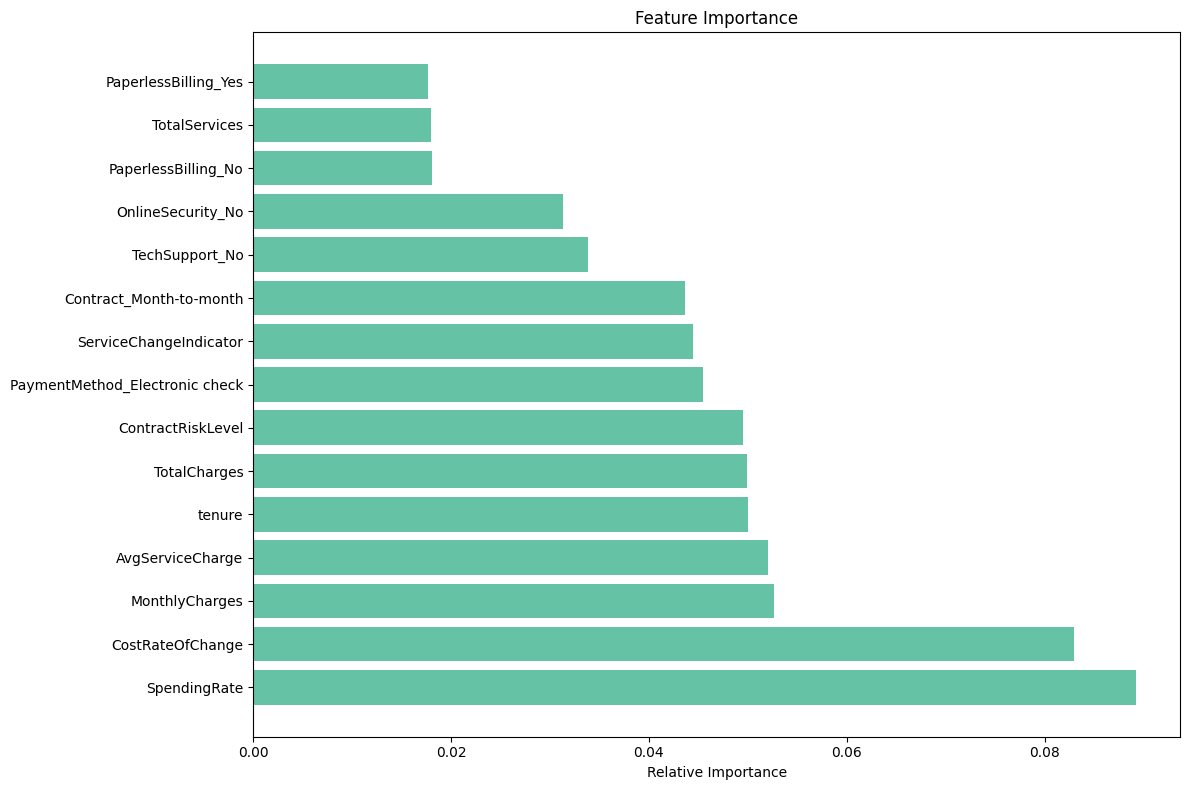


Calculating SHAP values (this may take a moment)...


100%|===================| 996/1000 [01:24<00:00]       

<Figure size 1000x800 with 0 Axes>

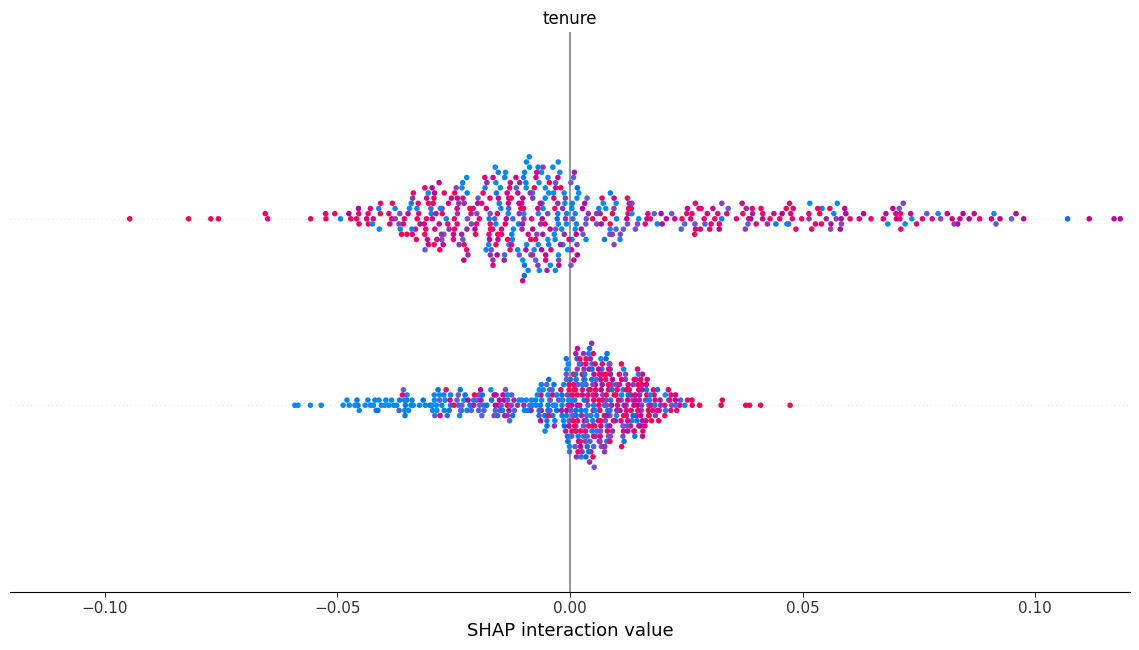

SHAP analysis skipped due to error: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 50


<Figure size 1000x600 with 0 Axes>

In [37]:
pipeline = best_model['Pipeline']
model = pipeline.named_steps['classifier']
preprocessor = pipeline.named_steps['preprocessor']

# Get transformed feature names
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
if hasattr(ohe, 'get_feature_names_out'):
    cat_features = ohe.get_feature_names_out(categorical_features)
else:
    cat_features = ohe.get_feature_names(categorical_features)
feature_names = list(numerical_features) + list(cat_features)


# Get feature importance for the best model
if best_model['Model'] in ['Random Forest', 'Gradient Boosting', 'XGBoost']:
    # For tree-based models
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        # Print top features
        print("\nTop 15 most important features:")
        for i in range(min(15, len(feature_names))):
            if indices[i] < len(feature_names):
                print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

        # Plot feature importance
        plt.figure(figsize=(12, 8))
        plt.title('Feature Importance')
        plt.barh(range(min(15, len(indices))),
                [importances[i] for i in indices[:15]],
                align='center')
        plt.yticks(range(min(15, len(indices))), [feature_names[i] for i in indices[:15]])
        plt.xlabel('Relative Importance')
        plt.tight_layout()
        plt.show()

elif best_model['Model'] == 'Logistic Regression':
    # For logistic regression
    coefficients = model.coef_[0]
    indices = np.argsort(np.abs(coefficients))[::-1]

    # Print top features
    print("\nTop 15 most influential features:")
    for i in range(min(15, len(feature_names))):
        if indices[i] < len(feature_names):
            print(f"{i+1}. {feature_names[indices[i]]}: {coefficients[indices[i]]:.4f}")

    # Plot feature coefficients
    plt.figure(figsize=(12, 8))
    plt.title('Feature Coefficients')
    plt.barh(range(min(15, len(indices))),
            [coefficients[i] for i in indices[:15]],
            align='center')
    plt.yticks(range(min(15, len(indices))), [feature_names[i] for i in indices[:15]])
    plt.xlabel('Coefficient Value')
    plt.tight_layout()
    plt.show()


try:
    # Transform a sample of training data
    X_train_sample = X_train.sample(min(500, len(X_train)), random_state=42)
    X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train_sample)

    print("\nCalculating SHAP values (this may take a moment)...")

    if best_model['Model'] in ['Logistic Regression', 'Random Forest', 'Gradient Boosting']:
        explainer = shap.Explainer(model, X_train_transformed)
        shap_values = explainer(X_train_transformed)

        # Summary plot
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names, show=False)
        plt.tight_layout()
        plt.show()

        # Dependence plot for top feature
        top_feature_idx = np.argmax(np.abs(shap_values.values).mean(0))
        plt.figure(figsize=(10, 6))
        shap.dependence_plot(top_feature_idx, shap_values.values, X_train_transformed,
                           feature_names=feature_names, show=False)
        plt.title(f'SHAP Dependence Plot for {feature_names[top_feature_idx]}')
        plt.tight_layout()
        plt.show()

        print("SHAP analysis complete.")
except Exception as e:
    print(f"SHAP analysis skipped due to error: {e}")

**Step 7: Customer Segmentation and Retention Strategies**

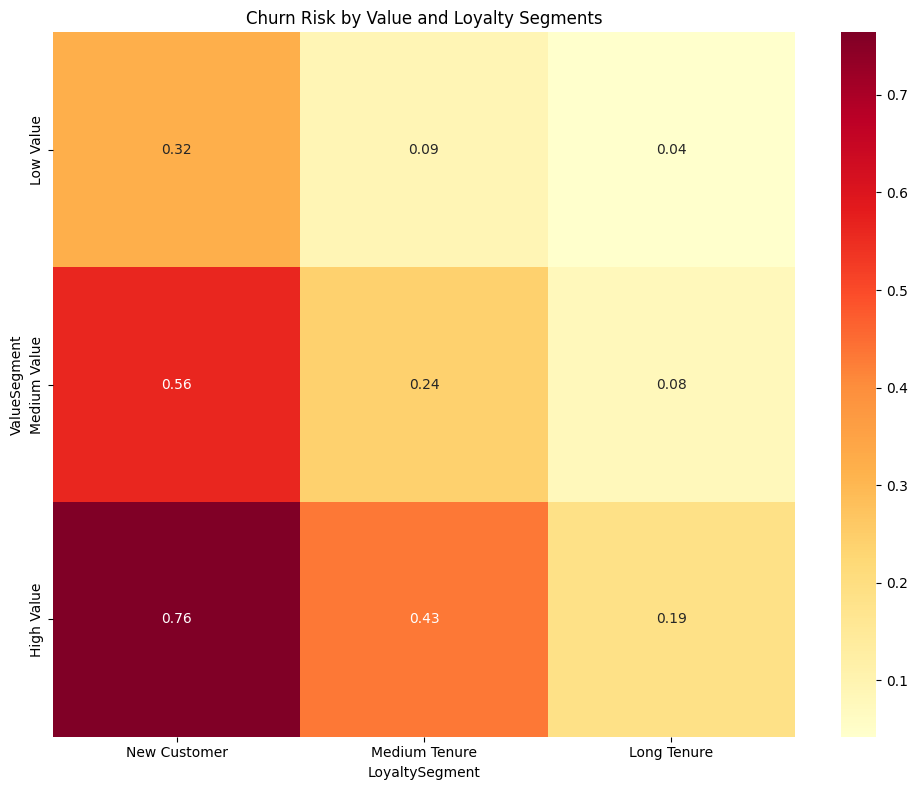


Key Characteristics of High-Risk Customers:

Contract Type Distribution:
Contract
Month-to-month    85.903337
One year          11.047181
Two year           3.049482
Name: proportion, dtype: float64

Internet Service Distribution:
InternetService
Fiber optic    65.103567
DSL            27.733026
No              7.163406
Name: proportion, dtype: float64

Payment Method Distribution:
PaymentMethod
Electronic check             52.531646
Mailed check                 18.383199
Bank transfer (automatic)    14.614499
Credit card (automatic)      14.470656
Name: proportion, dtype: float64


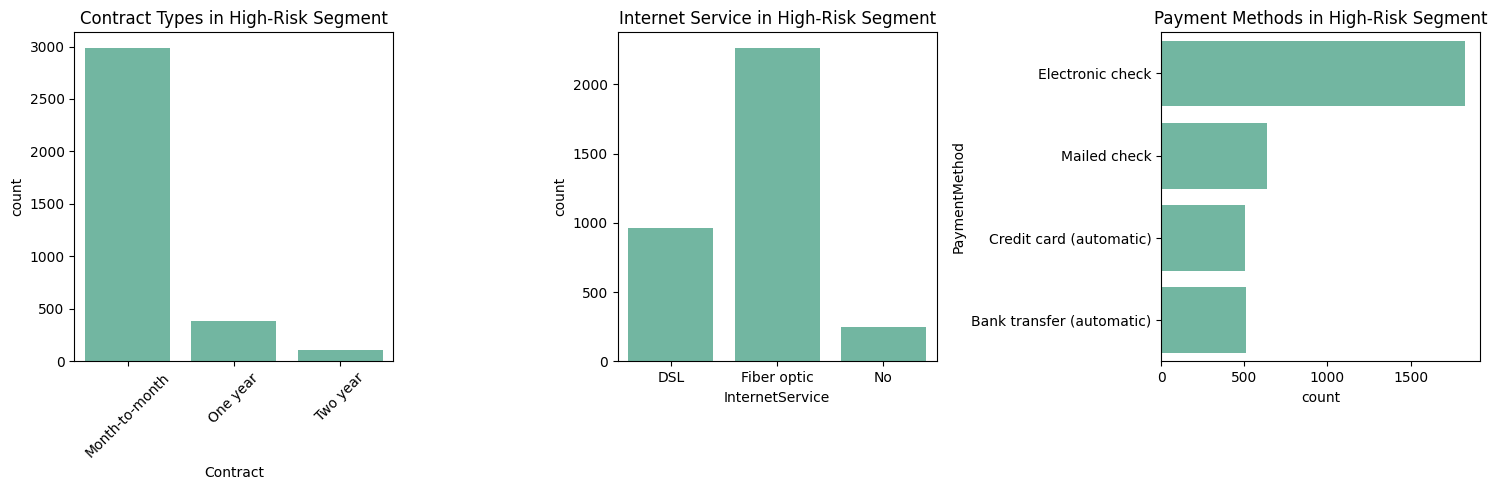

In [38]:
pipeline = best_model['Pipeline']

# Predict churn probabilities for all customers
df_copy = df.copy()
X = df_copy.drop('Churn', axis=1)

# Predict probabilities
churn_proba = pipeline.predict_proba(X)[:, 1]
df_copy['ChurnProbability'] = churn_proba

# Segment customers based on churn probability
df_copy['RiskSegment'] = pd.qcut(df_copy['ChurnProbability'], 4,
                                 labels=['Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk'])

# Create value segments based on monthly charges
df_copy['ValueSegment'] = pd.qcut(df_copy['MonthlyCharges'], 3,
                                  labels=['Low Value', 'Medium Value', 'High Value'])

# Create loyalty segments based on tenure
df_copy['LoyaltySegment'] = pd.qcut(df_copy['tenure'], 3,
                                    labels=['New Customer', 'Medium Tenure', 'Long Tenure'])

# %%
# Create a heatmap of churn probability by value and loyalty
plt.figure(figsize=(10, 8))
risk_pivot = df_copy.pivot_table(values='ChurnProbability',
                                 index='ValueSegment',
                                 columns='LoyaltySegment',
                                 aggfunc='mean')
sns.heatmap(risk_pivot, annot=True, cmap='YlOrRd', fmt='.2f')
plt.title('Churn Risk by Value and Loyalty Segments')
plt.tight_layout()
plt.show()

# %%
# Analyze key characteristics of high-risk customers
high_risk = df_copy[df_copy['RiskSegment'].isin(['High Risk', 'Very High Risk'])]

print("\nKey Characteristics of High-Risk Customers:")

# Contract type distribution
print("\nContract Type Distribution:")
print(high_risk['Contract'].value_counts(normalize=True) * 100)

# Internet service distribution
print("\nInternet Service Distribution:")
print(high_risk['InternetService'].value_counts(normalize=True) * 100)

# Payment method distribution
print("\nPayment Method Distribution:")
print(high_risk['PaymentMethod'].value_counts(normalize=True) * 100)

# %%
# Visualize key characteristics of high-risk customers
plt.figure(figsize=(15, 5))

# Contract Distribution
plt.subplot(1, 3, 1)
sns.countplot(x='Contract', data=high_risk)
plt.title('Contract Types in High-Risk Segment')
plt.xticks(rotation=45)

# Internet Service
plt.subplot(1, 3, 2)
sns.countplot(x='InternetService', data=high_risk)
plt.title('Internet Service in High-Risk Segment')

# Payment Method
plt.subplot(1, 3, 3)
sns.countplot(y='PaymentMethod', data=high_risk)
plt.title('Payment Methods in High-Risk Segment')

plt.tight_layout()
plt.show()





**Step 8: Develop Retention Strategies**


Retention Strategy Recommendations:

1. Contract Upgrade Strategy:
   - Target: 2986 high-risk month-to-month customers (85.9% of high-risk)
   - Average monthly value: $70.99
   - Recommended Action: Offer discounted 1-year contracts with price protection

2. Service Enhancement Strategy:
   - Target: 2574 high-risk customers without security (74.1% of high-risk)
   - Recommended Action: Offer free security trials and bundled tech support

3. Payment Method Optimization:
   - Target: 1826 high-risk electronic check customers (52.5% of high-risk)
   - Recommended Action: Offer discount for switching to automatic payments

4. High-Value Customer Retention Program:
   - Target: 1464 high-risk, high-value customers (42.1% of high-risk)
   - Average monthly value: $96.56
   - Recommended Action: Personalized retention offers and premium customer service

Financial Impact Analysis:
Total Customers at High/Very High Risk: 3476 (49.4% of customer base)
Average Customer Lifetime Value: $2096.

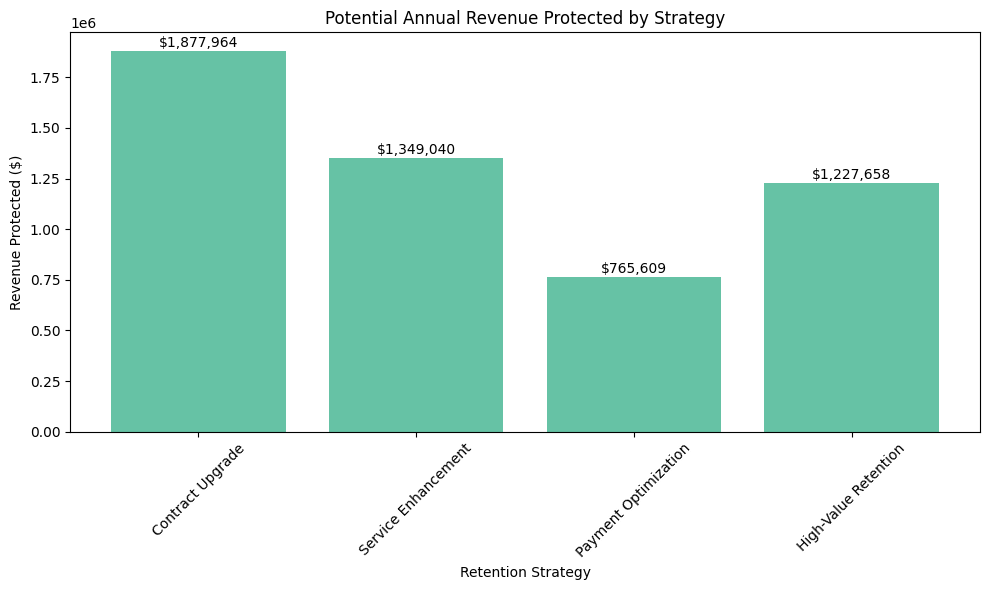

In [39]:
print("\nRetention Strategy Recommendations:")

# Strategy 1: Contract upgrades for month-to-month customers
month_to_month = high_risk[high_risk['Contract'] == 'Month-to-month']
strategy1_impact = len(month_to_month) / len(high_risk) * 100
print(f"\n1. Contract Upgrade Strategy:")
print(f"   - Target: {len(month_to_month)} high-risk month-to-month customers ({strategy1_impact:.1f}% of high-risk)")
print(f"   - Average monthly value: ${month_to_month['MonthlyCharges'].mean():.2f}")
print("   - Recommended Action: Offer discounted 1-year contracts with price protection")

# Strategy 2: Service enhancement for customers without security services
no_security = high_risk[high_risk['OnlineSecurity'] == 'No']
strategy2_impact = len(no_security) / len(high_risk) * 100
print(f"\n2. Service Enhancement Strategy:")
print(f"   - Target: {len(no_security)} high-risk customers without security ({strategy2_impact:.1f}% of high-risk)")
print("   - Recommended Action: Offer free security trials and bundled tech support")

# Strategy 3: Payment method optimization
electronic_check = high_risk[high_risk['PaymentMethod'] == 'Electronic check']
strategy3_impact = len(electronic_check) / len(high_risk) * 100
print(f"\n3. Payment Method Optimization:")
print(f"   - Target: {len(electronic_check)} high-risk electronic check customers ({strategy3_impact:.1f}% of high-risk)")
print("   - Recommended Action: Offer discount for switching to automatic payments")

# Strategy 4: High-value retention program
high_value_risk = high_risk[high_risk['ValueSegment'] == 'High Value']
strategy4_impact = len(high_value_risk) / len(high_risk) * 100
print(f"\n4. High-Value Customer Retention Program:")
print(f"   - Target: {len(high_value_risk)} high-risk, high-value customers ({strategy4_impact:.1f}% of high-risk)")
print(f"   - Average monthly value: ${high_value_risk['MonthlyCharges'].mean():.2f}")
print("   - Recommended Action: Personalized retention offers and premium customer service")

# %%
# Calculate potential financial impact of retention strategies
avg_customer_lifetime = df_copy['tenure'].mean()
avg_monthly_revenue = df_copy['MonthlyCharges'].mean()
avg_customer_value = avg_customer_lifetime * avg_monthly_revenue

total_at_risk_revenue = high_risk['MonthlyCharges'].sum() * 12  # Annual revenue at risk

print("\nFinancial Impact Analysis:")
print(f"Total Customers at High/Very High Risk: {len(high_risk)} ({len(high_risk)/len(df_copy)*100:.1f}% of customer base)")
print(f"Average Customer Lifetime Value: ${avg_customer_value:.2f}")
print(f"Annual Revenue at Risk: ${total_at_risk_revenue:,.2f}")

# Success rate assumptions for different strategies
success_rates = {
    'Contract Upgrade': 0.30,
    'Service Enhancement': 0.25,
    'Payment Optimization': 0.20,
    'High-Value Retention': 0.40
}

# Calculate potential savings
strategy1_savings = len(month_to_month) * avg_customer_value * success_rates['Contract Upgrade']
strategy2_savings = len(no_security) * avg_customer_value * success_rates['Service Enhancement']
strategy3_savings = len(electronic_check) * avg_customer_value * success_rates['Payment Optimization']
strategy4_savings = len(high_value_risk) * avg_customer_value * success_rates['High-Value Retention']

total_potential_savings = strategy1_savings + strategy2_savings + strategy3_savings + strategy4_savings

print(f"\nPotential Revenue Protected (assuming conservative success rates):")
print(f"1. Contract Upgrade Strategy: ${strategy1_savings:,.2f}")
print(f"2. Service Enhancement Strategy: ${strategy2_savings:,.2f}")
print(f"3. Payment Method Optimization: ${strategy3_savings:,.2f}")
print(f"4. High-Value Retention Program: ${strategy4_savings:,.2f}")
print(f"\nTotal Potential Annual Revenue Protected: ${total_potential_savings:,.2f}")
print(f"ROI Potential: {total_potential_savings/total_at_risk_revenue*100:.1f}% of at-risk revenue")

# %%
# Visualize financial impact
strategies = ['Contract Upgrade', 'Service Enhancement', 'Payment Optimization', 'High-Value Retention']
savings = [strategy1_savings, strategy2_savings, strategy3_savings, strategy4_savings]

plt.figure(figsize=(10, 6))
bars = plt.bar(strategies, savings)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5000,
            f'${height:,.0f}',
            ha='center', va='bottom', rotation=0)

plt.title('Potential Annual Revenue Protected by Strategy')
plt.xlabel('Retention Strategy')
plt.ylabel('Revenue Protected ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Step 9: Summary and Recommendations**

In [42]:
print("\nTelecom Customer Churn Prediction Summary\n" + "="*40)
print(f"Best Model: {best_model['Model']}")
print(f"Model Performance: Accuracy = {best_model['Accuracy']:.4f},F1 Score = {best_model['F1 Score']:.4f}, PR AUC = {best_model['PR AUC']:.4f}")
print(f"High-Risk Customers: {len(high_risk)} customers")
print("\nTop Churn Factors:")
print("1. Contract type - month-to-month contracts have significantly higher churn")
print("2. Payment method - electronic check users are more likely to churn")
print("3. Service offerings - customers without security services churn more frequently")
print("4. Tenure - newer customers have higher churn rates")

print("\nRecommended Retention Strategies:")
print("1. Contract Upgrade Strategy for month-to-month customers")
print("2. Service Enhancement Strategy for customers without security services")
print("3. Payment Method Optimization for electronic check users")
print("4. High-Value Customer Retention Program for high-value at-risk customers")

print(f"\nPotential Financial Impact: ${total_potential_savings:,.2f} annual revenue protected")


Telecom Customer Churn Prediction Summary
Best Model: Random Forest
Model Performance: Accuracy = 0.7848,F1 Score = 0.5737, PR AUC = 0.6114
High-Risk Customers: 3476 customers

Top Churn Factors:
1. Contract type - month-to-month contracts have significantly higher churn
2. Payment method - electronic check users are more likely to churn
3. Service offerings - customers without security services churn more frequently
4. Tenure - newer customers have higher churn rates

Recommended Retention Strategies:
1. Contract Upgrade Strategy for month-to-month customers
2. Service Enhancement Strategy for customers without security services
3. Payment Method Optimization for electronic check users
4. High-Value Customer Retention Program for high-value at-risk customers

Potential Financial Impact: $5,220,271.47 annual revenue protected
